# Analyzing integration timescales with spectral coherence

In [1]:
%matplotlib inline
import cortex
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import h5py

#### Load language data

In [2]:
path = '/Users/jiamingxu/Desktop/Language_straightenting/data/language/AA_wheretheressmoke.hf5'
with h5py.File(path, 'r') as file:
    file_name = list(file.keys())[0]
    response_trials = np.array(file[file_name])
    print(response_trials.shape) 

subject, xfm = 'AA', '20180905AA-sg-auto'
mask = cortex.db.get_mask(subject, xfm)

(10, 291, 95556)


#### Load vision data 

In [57]:
path = '/Users/jiamingxu/Desktop/Language_straightenting/data/vision/AHfs_sintel.hf5'
with h5py.File(path, 'r') as file:
    file_name = list(file.keys())[0]
    #response_trials_temp = np.array(file[file_name])
    #response_trials = response_trials_temp[:,:,:94244]
    response_trials = np.array(file[file_name])
    print(response_trials.shape) 

subject, xfm = 'AHfs', '20180816AH-sg'
mask = cortex.db.get_mask(subject, xfm)

(2, 135, 94251)


#### Estimate PSD for each frequency bin

Re-normalize after averaging across repeats for each voxel

In [3]:
avg_reps = np.mean(response_trials,0)
means = np.mean(avg_reps,0)
stds = np.std(avg_reps,0)
norm_avg_reps = (avg_reps - means)/stds
norm_vars = np.var(norm_avg_reps,0)
print("norm var: ",norm_vars)

norm var:  [1. 1. 1. ... 1. 1. 1.]


In [4]:
freqs, Pxx = sp.signal.welch(response_trials.mean(0), fs=0.5, axis=0, nperseg=64) #language
#freqs, Pxx = sp.signal.welch(norm_avg_reps, fs=0.5, axis=0, nperseg=64) #language re-normalized

#freqs, Pxx = sp.signal.welch(response_trials.mean(0), fs=0.5, axis=0, nperseg=64, noverlap = 56) #vision
#freqs, Pxx = sp.signal.welch(norm_avg_reps, fs=0.5, axis=0, nperseg=64, noverlap = 56) #vision re-normalized

Pxx.shape

(33, 95556)

Notes: averaged across repeats; fs = sampling freq, each data point represents a 2-s interval; axis = 0 the Welch method should
be applied to the first axis of the input array; nperseg = 64 sets the length of each segment in the Welch method
returns 2 arrays: freqs - frequency bins; Pxx - estimates PSD for each frequency bin

In [ ]:
# (backup) sort for each frequency and print the 5 smallest values 
sorted_pxx = np.argsort(Pxx, axis = 1) # get order indices
smallest_idx = sorted_pxx[:, :5] 
row_idx = np.arange(Pxx.shape[0])[:, np.newaxis]
smallest_pxx = Pxx[row_idx,smallest_idx]
#print(smallest_pxx)
#print(smallest_idx)
np.min(Pxx), np.max(Pxx)

#### Plot average PSD of each frequency bin (whole brain)

Text(0, 0.5, 'PSD (W/Hz)')

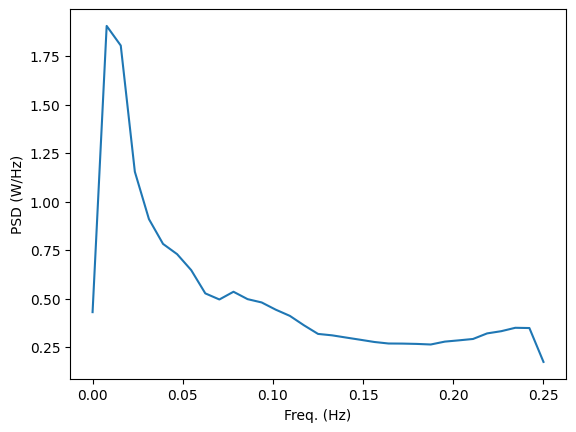

In [5]:
mu_pxx = np.mean(Pxx,axis = 1) # averaged across all voxels
mu_pxx.shape
plt.plot(freqs, mu_pxx.T)

plt.xlabel('Freq. (Hz)')
plt.ylabel('PSD (W/Hz)')

#### Plot average PSD of each frequency bin (selected ROIs)

In [6]:
# choose functional roi 
#f_rois = ['V1','hMT','FFA']  
f_rois = ['AC']
f_roi_voxs = {} # get indices of roi voxels in cortical map
# get 3d mask of voxels that belong to roi
roi_masks = cortex.utils.get_roi_masks(subject, xfm, roi_list=f_rois, gm_sampler='cortical', split_lr=False, threshold=None, return_dict=True)
for roi in f_rois:
    roi_mask = roi_masks[roi]
    f_roi_voxs[roi] = np.where(roi_mask[np.where(mask)])[0]

Cutting 0 overlapping voxels (should be < ~50)


In [7]:
%cd 'data/rois'

/Users/jiamingxu/Desktop/Language_straightenting/data/rois


/Users/jiamingxu/miniconda3/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [8]:
# choose anatomical roi (PFC & precuneus)
a_roi = ['parsopercularis','parstriangularis','superiorfrontal','rostralmiddlefrontal','caudalmiddlefrontal','frontalpole','precuneus']
roi_data = np.load(f'{subject}_roi.npy', allow_pickle=True).item()
a_roi_voxs = {}
for roi in a_roi:
    a_roi_voxs[roi] = roi_data[roi]

In [9]:
# combine PFC rois
rois_to_combine = [
    'parsopercularis',
    'parstriangularis',
    'superiorfrontal',
    'rostralmiddlefrontal',
    'caudalmiddlefrontal',
    'frontalpole'
]
pfc_voxs = []
for roi in rois_to_combine:
    pfc_voxs.extend(a_roi_voxs[roi])
    
pfc_voxs = list(set(pfc_voxs)) # remove potential duplicates

a_roi_voxs['prefrontal'] = pfc_voxs # update dict 

for roi in rois_to_combine: # remove old keys
    del a_roi_voxs[roi]

In [10]:
for key, value in a_roi_voxs.items():
    print(f"{key}: {len(value)} items")

precuneus: 2845 items
prefrontal: 15222 items


In [11]:
roi_voxs = {**f_roi_voxs, **a_roi_voxs}

In [12]:
len(roi_voxs)
for key, value in roi_voxs.items():
    print(f"{key}: {len(value)} items")

AC: 2124 items
precuneus: 2845 items
prefrontal: 15222 items


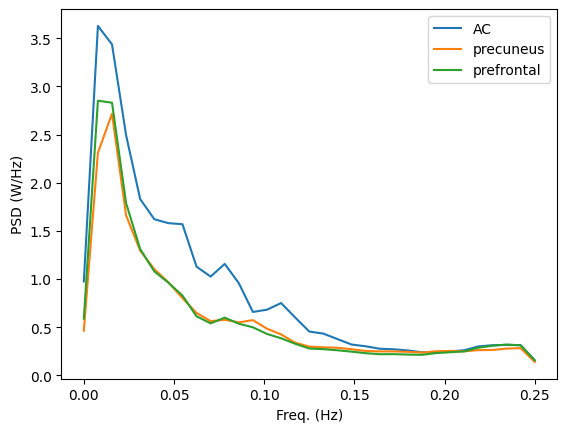

In [13]:
for roi in roi_voxs:
    mu_roi_pxx = np.mean(Pxx[:,roi_voxs[roi]], axis=1)
    plt.plot(freqs, mu_roi_pxx.T,label=roi)
plt.xlabel('Freq. (Hz)')
plt.ylabel('PSD (W/Hz)')
plt.legend()

#### Plot center of mass for each frequency spectrum (weighted by PSD) 

In [125]:
Pxx.shape

(33, 95556)

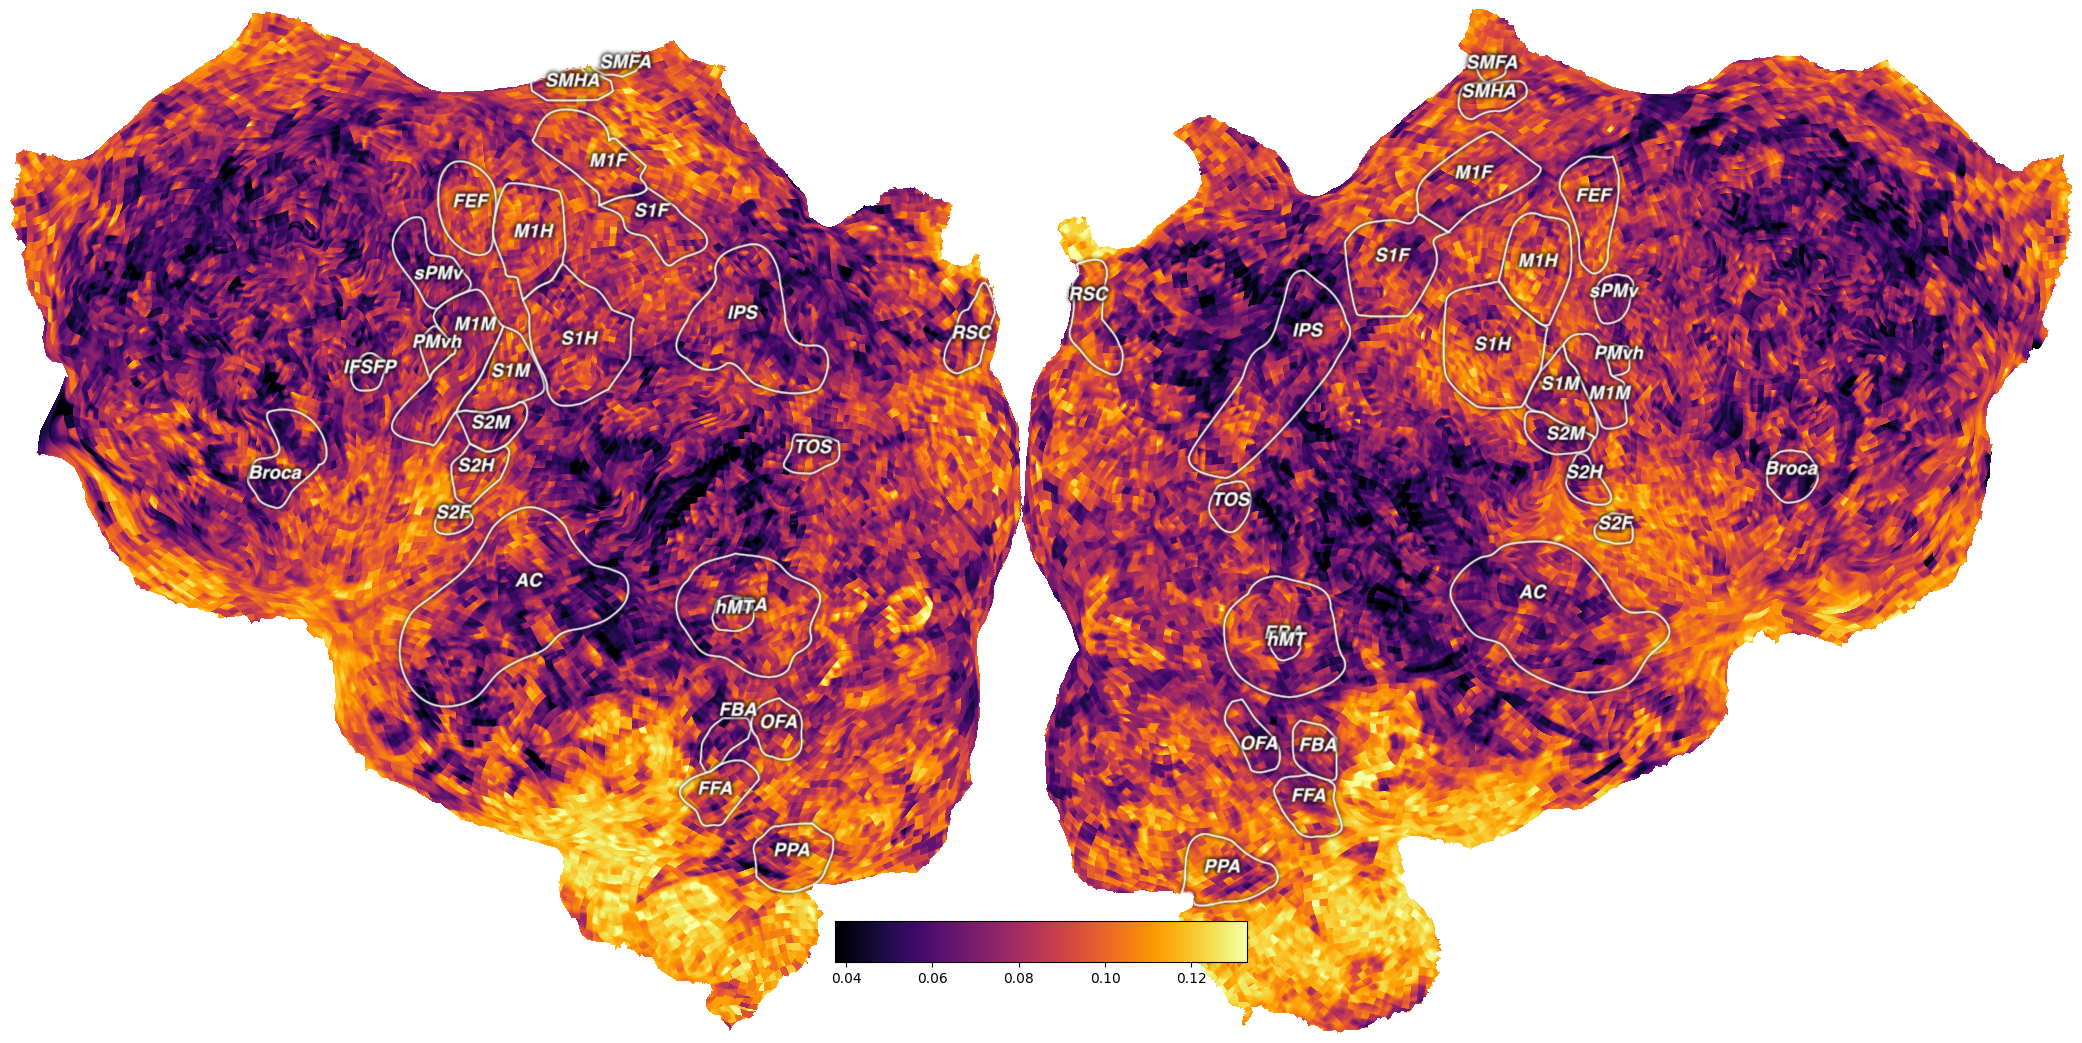

In [124]:
# Plot with pycortex
vol_data = np.average(np.broadcast_to(freqs[:, None], Pxx.shape), weights=Pxx, axis=0) # weighted average of frequency bins by power
vol = cortex.Volume(vol_data, subject, xfmname=xfm, cmap='inferno')
cortex.quickshow(vol);

In [ ]:
# visualize in 3D
cortex.webshow(vol, port=1420);

## Compute coherence for repeat #1 and #2

In [116]:
# language non-nan
freqs, coherence = sp.signal.coherence(response_trials[0, ...], response_trials[1, ...], fs=0.5, axis=0, nperseg=32)
freqs.shape, coherence.shape, coherence.mean()
#nperseg is the instead of fourier transform the whole signal, break it down into segments, this is the length of the
# segment, this determines how many frequency bins we will have in the output, this is upper bounded by the length of
# the stimulus

((17,), (17, 95556), 0.06945680136458285)

In [120]:
Pxx.shape

(33, 95556)

In [97]:
# vision
freqs, coherence_nan = sp.signal.coherence(response_trials[0, ...], response_trials[1, ...], fs=0.5, axis=0, nperseg=32)
# replace NaN values with the minimum non-NaN value
min_non_nan = np.nanmin(coherence_nan)
coherence = np.nan_to_num(coherence_nan, nan=min_non_nan)
freqs.shape, coherence.shape, coherence.mean()

/Users/jiamingxu/miniconda3/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:1629: RuntimeWarning: invalid value encountered in divide
  Cxy = np.abs(Pxy)**2 / Pxx / Pyy


((17,), (17, 94251), 0.16905444740284964)

#### Plot coherence spectrum (one random voxel from each ROI)

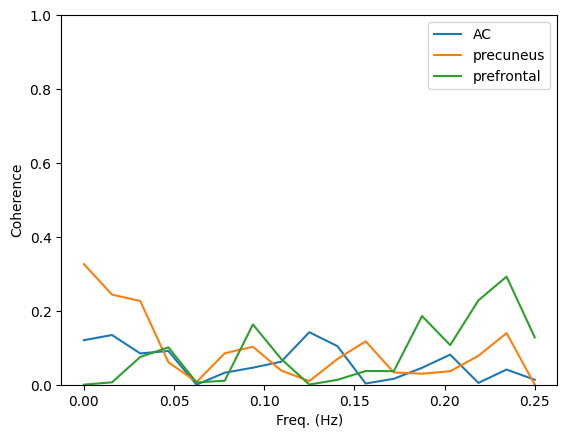

In [20]:
import random
for roi in roi_voxs:
    randvox = random.choice(roi_voxs[roi])
    plt.plot(freqs, coherence[:, randvox].T,label=roi)
plt.xlabel('Freq. (Hz)')
plt.ylabel('Coherence')
plt.ylim(0, 1) # Coherence can only fall in this range
plt.legend()

#### Visualize coherence spectrum for a selected functional ROI

This is an SNR measure at each frequency band (how much response that's repeatable in each frequency band, this is normalized for the magnitude of the signals).

CPU times: user 18.9 ms, sys: 8.97 ms, total: 27.8 ms
Wall time: 25.2 ms


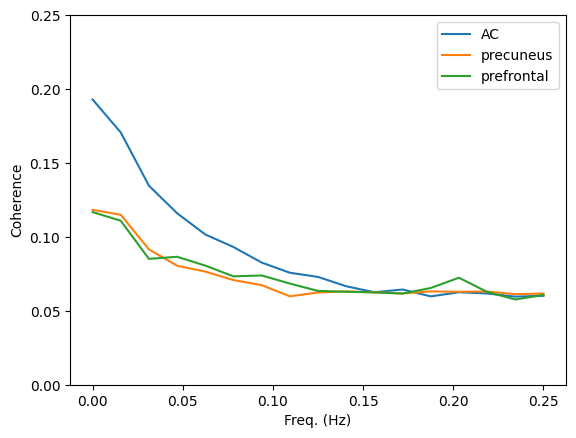

In [118]:
%%time
for roi in roi_voxs:
    mu_roi_coh = np.mean(coherence[:,roi_voxs[roi]], axis=1)
    plt.plot(freqs, mu_roi_coh.T,label=roi)
plt.xlabel('Freq. (Hz)')
plt.ylabel('Coherence')
plt.ylim(0, 0.25) # Coherence can only fall in this range
plt.legend()

#### Plot center of mass for each frequency spectrum (weighted by coherence) 

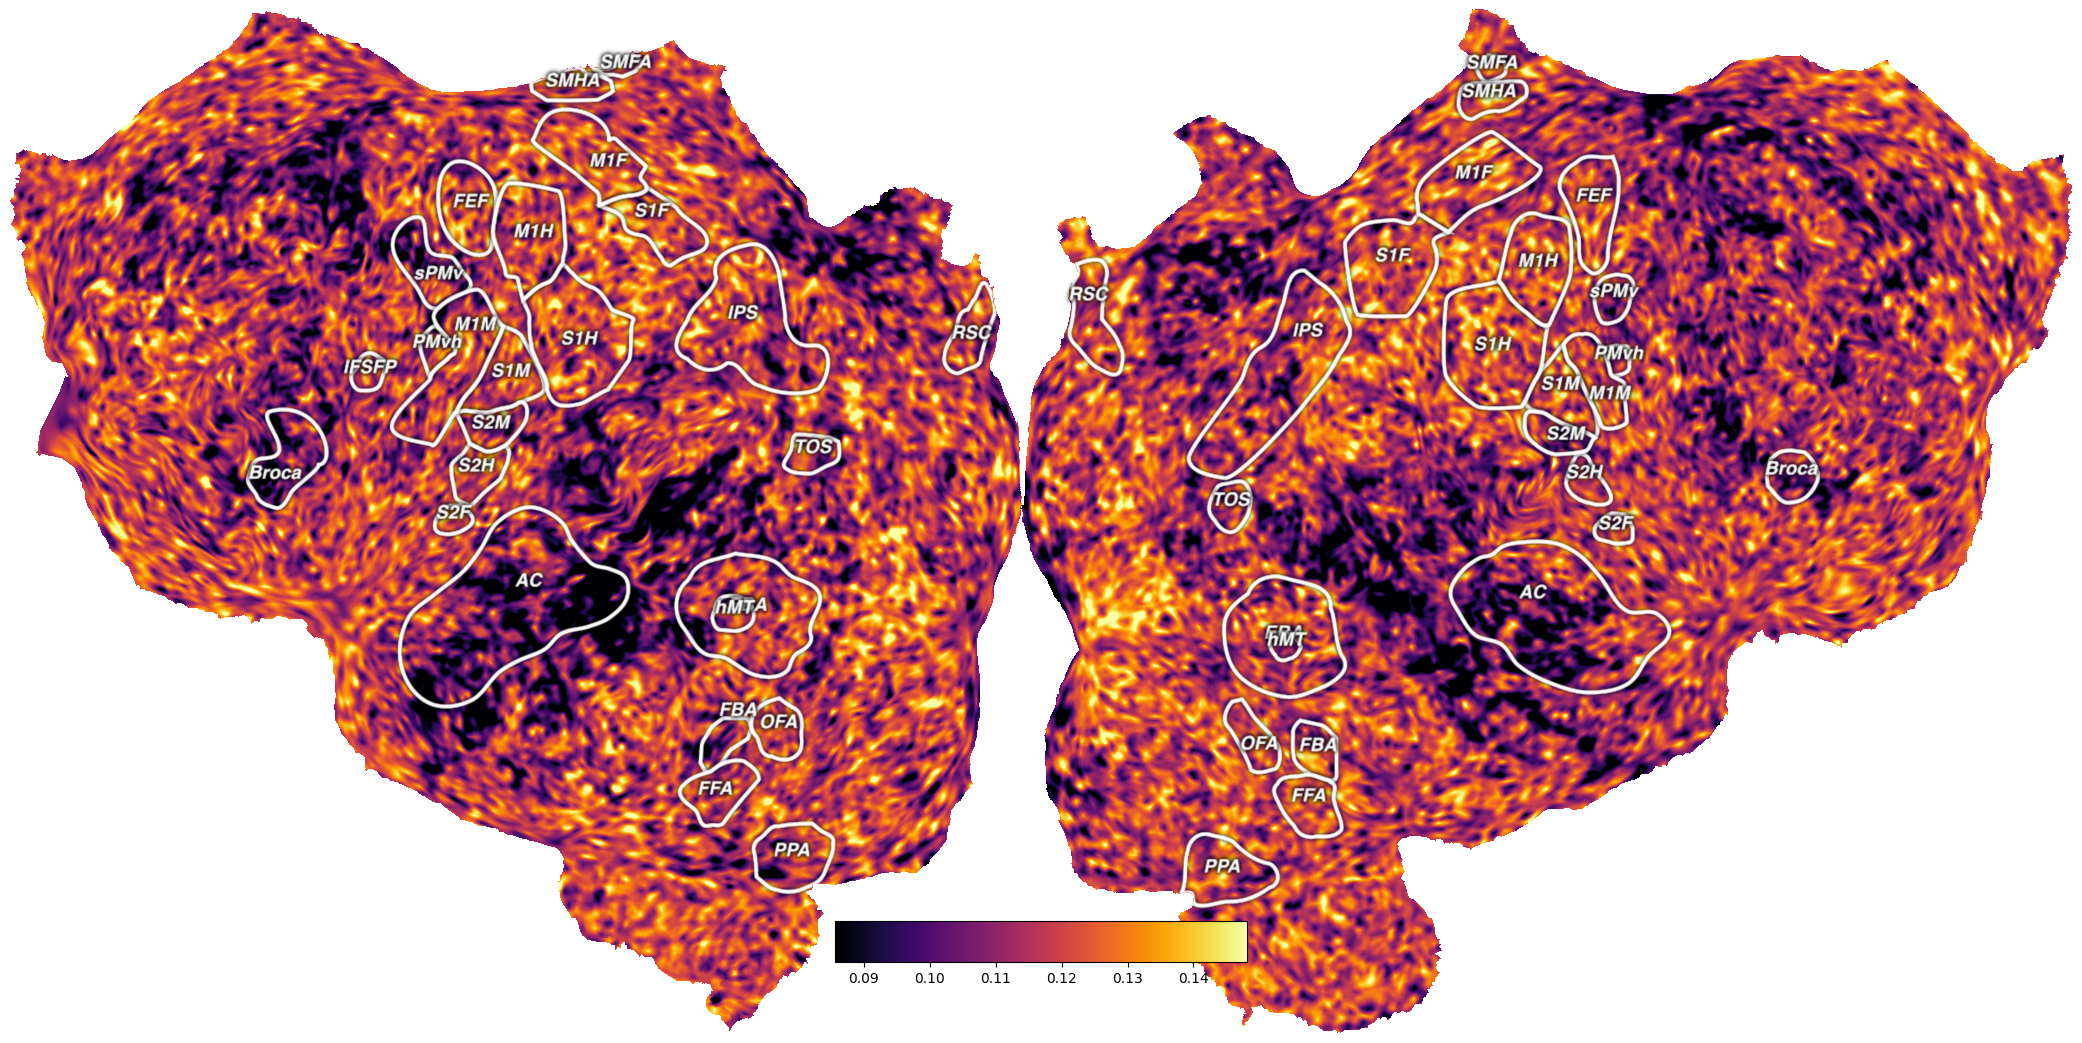

In [119]:
flatmap_kwargs = {'recache': False, 'pixelwise': True, 'sampler': 'trilinear',
    'height': 1024, 'with_rois': True, #'with_labels': False, 
    'with_curvature': True, 'curvature_threshold': True, 'linewidth': 4,
    'nanmean': True}

# Plot with pycortex
# get weighted average of frequency bins by coherence - find the center of mass of the coherence spectrum
vol_data = np.average(np.broadcast_to(freqs[:, None], coherence.shape), weights=coherence, axis=0) 
#vol_data[(coherence.mean(0) < 0.1) & (coherence.mean(0) > 0.13)] = np.nan # coherence threshold .09, should we filter out high frequency noise? 
#vol_data[coherence.mean(0) < 0.1] = np.nan # coherence threshold .09, should we filter out high frequency noise? 

vmin, vmax = np.nanpercentile(vol_data, [10, 100-10])
vol = cortex.Volume(vol_data, subject, xfmname=xfm, cmap='inferno', vmin=vmin, vmax=vmax)
cortex.quickshow(vol, **flatmap_kwargs);

#### Compute coherence for all combinations of repeats (for language data)

In [126]:
%%time
# compute coherence (all combinations)
from itertools import combinations
pairs = list(combinations(range(0, 10), 2))

freqs = np.zeros((len(pairs),17,1))
coherences = np.zeros((len(pairs),17,response_trials.shape[2]))
for i in range(len(pairs)):
    a,b = pairs[i]
    freq, coherence = sp.signal.coherence(response_trials[a, ...], response_trials[b, ...], fs=0.5, axis=0, nperseg=32)
    freqs[i,:,:] = freq.reshape((17,1))
    coherences[i,:,:] = coherence

freqs.shape, coherences.shape

CPU times: user 56.6 s, sys: 38.5 s, total: 1min 35s
Wall time: 1min 50s


((45, 17, 1), (45, 17, 95556))

#### Plot coherence spectrum (one random voxel from each ROI)

In [127]:
coherences_avg = np.mean(coherences, axis=0)
coherences_avg.shape

(17, 95556)

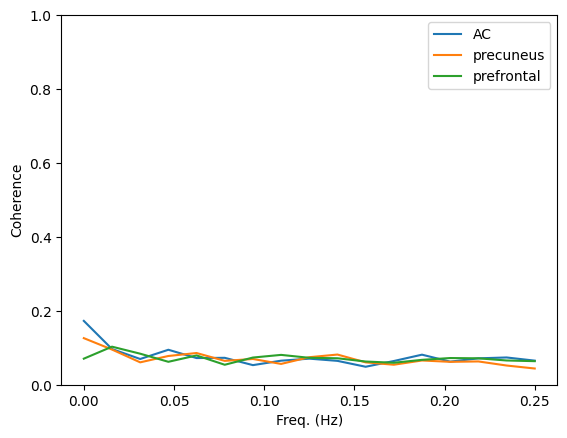

In [128]:
freqs = freqs[0]
for roi in roi_voxs:
    randvox = random.choice(roi_voxs[roi])
    plt.plot(freqs, coherences_avg[:, randvox].T,label=roi)
plt.xlabel('Freq. (Hz)')
plt.ylabel('Coherence')
plt.ylim(0, 1) # Coherence can only fall in this range
plt.legend()

#### Visualize coherence spectrum for a selected functional ROI

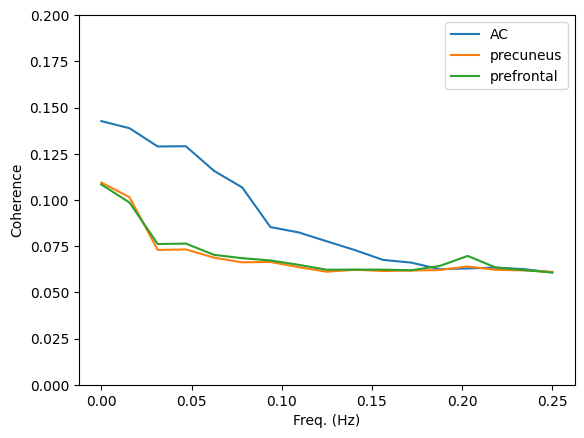

In [129]:
for roi in roi_voxs:
    mu_roi_coh = np.mean(coherences_avg[:,roi_voxs[roi]], axis=1)
    plt.plot(freqs, mu_roi_coh.T,label=roi)
plt.xlabel('Freq. (Hz)')
plt.ylabel('Coherence')
plt.ylim(0, 0.2) # Coherence can only fall in this range
plt.legend()

In [84]:
flatmap_kwargs = {'recache': False, 'pixelwise': True, 'sampler': 'trilinear',
    'height': 1024, 'with_rois': True, #'with_labels': False, 
    'with_curvature': True, 'curvature_threshold': True, 'linewidth': 4,
    'nanmean': True}

# get weighted average of frequency bins by coherence - find the center of mass of the coherence spectrum
weighted_avgs = np.zeros((len(pairs),coherences.shape[2]))
for i in range(len(pairs)):
    vol_data_temp = np.average(np.broadcast_to(freqs, coherences[0,:,:].shape), weights=coherences[i,:,:], axis=0) 
    #vol_data_temp[coherences[i,:,:].mean(0) < 0.04] = np.nan #filtering, what would be an appropriate value??
    weighted_avgs[i,:] = vol_data_temp

vol_data = weighted_avgs.mean(0)
vmin, vmax = np.nanpercentile(vol_data, [10, 100-10])
vol = cortex.Volume(vol_data, subject, xfmname=xfm, cmap='inferno', vmin=vmin, vmax=vmax)
cortex.quickshow(vol, **flatmap_kwargs);

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (17,)  and requested shape (17,95556)

In [17]:
vmin, vmax

(0.11177389383503251, 0.1250895927091468)

In [ ]:
cortex.webshow(vol, port=1420);